# Question 1: Graph Classification

In this question we will be exploring graph classification on the dataset provided.

Overall, we will explore ways to implement graph level classification using GCNs; explore the given dataset and see how we can improve the GCN & training process overall to get a higher score on the dataset.

### HELPER FUNCTION & IMPORTS:

In [3]:
#Import Statements
import json
import torch
import os
import torch
import random
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import networkx as nx
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

In [4]:
TRAIN_FILE_NAME = "q1_graph_classification_main_train.json"
EVAL_FILE_NAME = "q1_graph_classification_main_eval.json"

TRAIN_DATA_PATH = os.path.join("data",TRAIN_FILE_NAME)
EVAL_DATA_PATH = os.path.join("data",EVAL_FILE_NAME)

In [5]:
# Training function
def train_epoch(model, dataset, optimizer, criterion, return_embeddings=False, **kwargs):
    model.train()
    total_loss = 0
    all_embeddings_H1 = []
    all_labels_H1 = []

    for X, A, label in dataset:
        optimizer.zero_grad()

        # Forward pass with optional embeddings
        if return_embeddings:
            output, H1, _ = model(A, X, return_embeddings=True, **kwargs)
            all_embeddings_H1.append(H1.detach().cpu().numpy())  # Store H1 embeddings
        else:
            output = model(A, X, **kwargs)

        # Prepare label for BCELoss
        adjusted_label = 1 if label == 1 else 0
        label_tensor = torch.tensor([float(adjusted_label)], dtype=torch.float)
        all_labels_H1.append(label_tensor.detach().cpu().numpy())

        # Flatten the output to match the label tensor shape
        output_flat = output.view(-1)

        # Compute loss
        loss = criterion(output_flat, label_tensor)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / len(dataset)

    if return_embeddings:
        return average_loss, (all_embeddings_H1,all_labels_H1)
    else:
        return average_loss


# Testing function
def test(model, dataset, **kwargs):
    model.eval()
    true_labels = []
    predicted_labels = []
    correct = 0

    with torch.no_grad():
        for X, A, label in dataset:
            output = model(A, X, **kwargs)

            # Convert sigmoid output to binary prediction
            predicted = (output >= 0.5).int().item()

            # Adjust labels to match binary predictions (0 and 1)
            adjusted_label = 1 if label == 1 else 0

            true_labels.append(adjusted_label)
            predicted_labels.append(predicted)
            correct += (predicted == adjusted_label)

    accuracy = correct / len(dataset)
    return true_labels, predicted_labels, accuracy


In [6]:
# Functions to load the data
def create_Adj_matrix(N, edge_index):
    """Creates the adjacency matrix"""
    A = torch.zeros((N, N), dtype=torch.float)
    for idx, jdx in edge_index:
        A[idx, jdx] = 1
        A[jdx, idx] = 1
    return A

def read_json_data(file_path, has_label=True):
    with open(file_path, 'r') as f:
        data = json.load(f)
        
    graph_data = []
    for item in data:
        X = torch.tensor(item['features'], dtype=torch.float)
        N = len(X)
        A = create_Adj_matrix(N, item['edge_index'])
        if has_label:
            y = torch.tensor(item['label'], dtype=torch.long)
        else:
            y = None
        
        graph_data.append((X,A,y))
    
    return graph_data


## Question 1.1 - Graph-Level Aggregation and Training

### Graph Convolutional Network (GCN)

We are going to use a 2-layer GCN for the **binary node classification** task on the heterogeneous graph. Below, you can see the mathematical representation to generate predictions from GCN.

The feature update rule for the next layer $ H_{k+1} $ in a graph convolutional network is given by the equation

$$
$$

where  $\tilde{D}$ is the degree matrix with added self-loops, $\tilde{A}$ is the adjacency matrix with self-loops, $H_k$ are the features from the previous layer, $ \Omega_k $ is the weight matrix at layer $ k $, $\Beta_k$ is the bias vector at layer $k$, and $\sigma $ denotes the activation function.


$\tilde{D}^{-1/2} \tilde{A} \tilde{D}^{-1/2}$ is the normalized adjacency matrix with self-loops. Below, you need to implement this normalization function.

In [7]:
# Helper function to normalise the A matrix
def symmetric_normalize(A_tilde):
    """
    Performs symmetric normalization of A_tilde (Adj. matrix with self loops):
      A_norm = D^{-1/2} * A_tilde * D^{-1/2}
    Where D_{ii} = sum of row i in A_tilde.

    A_tilde (N, N): Adj. matrix with self loops
    Returns:
      A_norm : (N, N)
    """

    eps = 1e-5
    d = A_tilde.sum(dim=1) + eps
    
    D_inv = torch.diag(torch.pow(d, -0.5))
    return D_inv @ A_tilde @ D_inv


### Q1.1.a - Graph-Level GCN

Implement three graph-level aggregation methods: sum, mean, and max. A GCN implemen-
tation is provided, and your task is to adapt it into a graph-level GCN by integrating different
aggregation functions.

In [8]:
# SOLUTION Q1.1.a

# ####################################################
# MODIFY THE CODE BELOW 
# ####################################################
class MyGCNLayer(nn.Module):
    """
    A single layer of a Graph Convolutional Network (GCN).
    """
    def __init__(self, input_dim, output_dim, use_nonlinearity=True):
        super(MyGCNLayer, self).__init__()
        self.use_nonlinearity = use_nonlinearity
        self.Omega = nn.Parameter(torch.randn(input_dim, output_dim) * torch.sqrt(torch.tensor(2.0) / (input_dim + output_dim)))
        self.beta = nn.Parameter(torch.zeros(output_dim))

    def forward(self, H_k, A_normalized):
        agg = torch.matmul(A_normalized, H_k) # local agg
        H_k_next = torch.matmul(agg, self.Omega) + self.beta
        return F.relu(H_k_next) if self.use_nonlinearity else H_k_next

class MyGraphNeuralNetwork(nn.Module):
    """
    A simple Graph Neural Network model using two layers of Graph Convolutional Network (GCN)
    for binary classification. The sigmoid activation is applied in the output layer only if
    use_nonlinearity is set to True.
    """
    def __init__(self, input_dim, hidden_dim):
        super(MyGraphNeuralNetwork, self).__init__()

        # Define GCN layers
        self.gcn1 = MyGCNLayer(input_dim, hidden_dim, True)
        self.gcn2 = MyGCNLayer(hidden_dim, 1, False)

    def forward(self, A, X, **kwargs):
        # Pass through GCN layers
        H1 = self.gcn1(X, A)
        H2 = self.gcn2(H1, A)  # Output shape: (num_nodes, 1)


        output = torch.sigmoid(H2)
        graph_output = output

        if torch.isnan(graph_output).any():
            graph_output = torch.where(torch.isnan(graph_output), torch.zeros_like(graph_output), graph_output)
        
        if kwargs.get("graph_aggregation_method", None) == "sum":
            graph_output = torch.sum(graph_output, dim=0)
            # This gives an error in the binary cross-entropy loss function: RuntimeError: all elements of input should be between 0 and 1
            # Because sum is over 1
            # So apply tanh to sum, this avoids large values tending too close to 1 (with sigmoid). Since input sum is always positive, tanh gives a value between 0 and 1.
            graph_output = torch.tanh(graph_output)
        elif kwargs.get("graph_aggregation_method", None) == "mean":
            graph_output = torch.mean(graph_output, dim=0)
        elif kwargs.get("graph_aggregation_method", None) == "max":
            graph_output = torch.max(graph_output, dim=0).values


        if kwargs.get("return_embeddings", None):
            return graph_output, H1, H2
        else:
            return graph_output
    
# ####################################################
# END OF MODIFICATION
# ####################################################

### Test your solution runs for all three aggregation methods.

Note - the input dataset features have dimensionionality 10.

### A full end-2-end Training script (make sure the below runs)

You only need to modify the aggregation parameter in this case.

In [9]:
# Preparing the Basics:
# Load data
train_data = read_json_data(TRAIN_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label
eval_data = read_json_data(EVAL_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label

# Initialising the model

input_dim = 10
hidden_dim = 8

sum_aggregation_model = MyGraphNeuralNetwork(input_dim, hidden_dim)
print(sum_aggregation_model)

mean_aggregation_model = MyGraphNeuralNetwork(input_dim, hidden_dim)
print(mean_aggregation_model)

max_aggregation_model = MyGraphNeuralNetwork(input_dim, hidden_dim)
print(max_aggregation_model)


# Loss function and optimizer
sum_aggregation_model_criterion = nn.BCELoss()
sum_aggregation_model_optimizer = optim.Adam(sum_aggregation_model.parameters(), lr=0.001)

mean_aggregation_model_criterion = nn.BCELoss()
mean_aggregation_model_optimizer = optim.Adam(mean_aggregation_model.parameters(), lr=0.001)

max_aggregation_model_criterion = nn.BCELoss()
max_aggregation_model_optimizer = optim.Adam(max_aggregation_model.parameters(), lr=0.001)

MyGraphNeuralNetwork(
  (gcn1): MyGCNLayer()
  (gcn2): MyGCNLayer()
)
MyGraphNeuralNetwork(
  (gcn1): MyGCNLayer()
  (gcn2): MyGCNLayer()
)
MyGraphNeuralNetwork(
  (gcn1): MyGCNLayer()
  (gcn2): MyGCNLayer()
)


In [10]:
# Training the model
random.shuffle(train_data) # train_data shape: (30,10). model.gcn1 converts to (30,8). model.gcn2 converts to (30,1)

# Training
num_epochs = 10

models = [sum_aggregation_model, mean_aggregation_model, max_aggregation_model]
criteria = [sum_aggregation_model_criterion, mean_aggregation_model_criterion, max_aggregation_model_criterion]
optimizers = [sum_aggregation_model_optimizer, mean_aggregation_model_optimizer, max_aggregation_model_optimizer]

for i in range(len(models)):
    print(f"Training model with {["SUM", "MEAN", "MAX"][i]} aggregation")

    # Initialize a list to store loss values for visualization
    loss_values = []


    for epoch in range(num_epochs):
        # Train without returning embeddings for other epochs
        #note train_epoch accepts the additional param graph_aggregation_method and passes it (via kwargs) to the model.forward method.
        
        # ####################################################
        # MODIFY THE CODE BELOW 
        #  (note only aggregation param - and make sure to run all of them)
        # ####################################################    
        loss = train_epoch(models[i], train_data, optimizers[i], criteria[i], graph_aggregation_method=["sum", "mean", "max"][i])


        # ####################################################
        # END OF MODIFICATION
        # ####################################################   
        print(f"Epoch {epoch+1}, Loss: {loss}")
        loss_values.append(loss)
    
    print ("\n\n")

Training model with SUM aggregation
Epoch 1, Loss: 0.6252408975424485
Epoch 2, Loss: 0.5018584861784352
Epoch 3, Loss: 0.41604634357951503
Epoch 4, Loss: 0.36161902831714215
Epoch 5, Loss: 0.32948871474072294
Epoch 6, Loss: 0.31141036939725664
Epoch 7, Loss: 0.3002230745311835
Epoch 8, Loss: 0.2923610075804115
Epoch 9, Loss: 0.2855776800881745
Epoch 10, Loss: 0.2796746572660625



Training model with MEAN aggregation
Epoch 1, Loss: 0.688806234202771
Epoch 2, Loss: 0.6055613974899505
Epoch 3, Loss: 0.5718863588390928
Epoch 4, Loss: 0.5524273281634757
Epoch 5, Loss: 0.5405440467381568
Epoch 6, Loss: 0.5328258159711505
Epoch 7, Loss: 0.527782866731286
Epoch 8, Loss: 0.5239042637474609
Epoch 9, Loss: 0.5211100619229855
Epoch 10, Loss: 0.5183770710207296



Training model with MAX aggregation
Epoch 1, Loss: 0.6177125959612209
Epoch 2, Loss: 0.4961840504052044
Epoch 3, Loss: 0.4607387168806313
Epoch 4, Loss: 0.442781234059911
Epoch 5, Loss: 0.42891650865076925
Epoch 6, Loss: 0.41491803962377

In [11]:
for i in range(len(models)):
    print(f"Evaluating model with {["SUM", "MEAN", "MAX"][i]} aggregation")

    # Evaluate the model on the test set
    true_labels, predicted_labels, accuracy = test(models[i], eval_data, graph_aggregation_method=["sum", "mean", "max"][i])

    # Debug: Print true and predicted labels
    print("True labels:", true_labels)
    print("Predicted labels:", predicted_labels)

    # Calculate precision, recall (sensitivity), and F1-score
    precision = precision_score(true_labels, predicted_labels, average='macro')
    recall = recall_score(true_labels, predicted_labels, average='macro')
    f1 = f1_score(true_labels, predicted_labels, average='macro')

    # Print out the evaluation metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")

    print("\n\n")

Evaluating model with SUM aggregation
True labels: [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]
Predicted labels: [1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0]
Accuracy: 0.7833
Precision: 0.8273
Recall: 0.7833
F1-score: 0.7758



Evaluating model with MEAN aggregation
True labels: [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]
Predicted labels: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Accuracy: 0.5167
Precision: 0.7542
Recall: 0.5167
F1-score: 0.3693


### Q1.1.b. Graph-Level Training

Make modifications to the training script to:
1. Train the model and record the training loss and evaluation accuracy for each epoch.
2. Plot the test f1 for all three aggregation methods.

Use the provided functions:

• train model

• plot training and evaluation

In [25]:
# Helper function for plotting:

def plot_training_and_validation(graph1_vals, graph2_vals=None, aggregation="mean", graph1_label="Training Accuracy", graph2_label="Validation Accuracy", x_label="Epoch",title="Training Accuracy and Validation Accuracy Over Time"):
    """
    Plots the validation accuracy and training loss over epochs.
    Has been modified to plot either 1 or two axes, and any two labels for the graphs.
    Args:
        validation_losses: List of validation accuracies (or losses)
        training_losses: List of training accuracies (or losses)
        aggregation: Aggregation method used (default: "mean")
    """
    plt.figure(figsize=(10, 6))
    
    # Create figure with two y-axes
    fig, ax1 = plt.subplots(figsize=(10, 6))

    if graph2_vals:
        ax2 = ax1.twinx()
    
    # Plot training loss on the first y-axis. Modified to plot graph1_vals on the first y-axis
    epochs = range(1, len(graph1_vals) + 1)
    line1 = ax1.plot(epochs, graph1_vals, 'r-', label=f'{graph1_label}')
    ax1.set_xlabel(f"{x_label}")
    ax1.set_ylabel(f'{graph1_label}', color='r')
    ax1.tick_params(axis='y', labelcolor='r')
    
    # Plot validation accuracy on the second y-axis. Modified to optionally plot graph2_vals on the second y-axis
    if graph2_vals:
        line2 = ax2.plot(epochs, graph2_vals, 'b-', label=f'{graph2_label}')
        ax2.set_ylabel(f'{graph2_label}', color='b')
        ax2.tick_params(axis='y', labelcolor='b')
    
    # Add title and grid
    graph_title = f'{title}\nAggregation: {aggregation}'
    plt.title(graph_title)

    ax1.grid(True)
    
    # Add legend
    if graph2_vals:
        lines = line1 + line2
    else:
        lines = line1
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='upper right')
    
    plt.tight_layout()
    plt.show()

In [26]:
# SOLUTION Q1.1.b
# ####################################################
# MODIFY THE CODE BELOW 
# ####################################################  


def train_model(model, optimizer, criterion, train_dataset, validation_dataset, epochs, graph_aggregation_method, verbose):
    """Trains the model and records loss and validation accuracy
    Should return, train_losses, train_accuracy, validation_accuracy
    """
    random.shuffle(train_dataset)

    train_losses = []
    train_accs = []
    val_accs = []

    train_f1s = []
    val_f1s = []
    

    for epoch in range(epochs):
        loss = train_ epoch(model, train_dataset, optimizer, criterion, graph_aggregation_method=graph_aggregation_method)
        train_losses.append(loss)

        train_true_labels, train_predicted_labels, train_acc = test(model, train_dataset, graph_aggregation_method=graph_aggregation_method)
        train_accs.append(train_acc)
        train_f1s.append(f1_score(train_true_labels, train_predicted_labels, average='macro'))

        val_true_labels, val_predicted_labels, val_acc = test(model, validation_dataset, graph_aggregation_method=graph_aggregation_method)
        val_accs.append(val_acc)
        val_f1s.append(f1_score(val_true_labels, val_predicted_labels, average='macro'))

        # INCLUDE THiS STATEMENT IN YOUR CODE
        if verbose:
            print(f"Epoch {epoch+1}, Training Loss: {loss}, Train Accuracy: {train_acc}, Validation Accuracy: {val_acc:.4f}")


    return train_losses, train_accs, val_accs, train_f1s, val_f1s

# ####################################################
# END OF MODIFICATION
# ####################################################  

MyGraphNeuralNetwork(
  (gcn1): MyGCNLayer()
  (gcn2): MyGCNLayer()
)
MyGraphNeuralNetwork(
  (gcn1): MyGCNLayer()
  (gcn2): MyGCNLayer()
)
MyGraphNeuralNetwork(
  (gcn1): MyGCNLayer()
  (gcn2): MyGCNLayer()
)
Epoch 1, Training Loss: 0.9190068237774429, Train Accuracy: 0.696969696969697, Validation Accuracy: 0.5667
Epoch 2, Training Loss: 0.5124402881088882, Train Accuracy: 0.7878787878787878, Validation Accuracy: 0.5833
Epoch 3, Training Loss: 0.46175965253761125, Train Accuracy: 0.8068181818181818, Validation Accuracy: 0.5833
Epoch 4, Training Loss: 0.4439999630549485, Train Accuracy: 0.8068181818181818, Validation Accuracy: 0.5667
Epoch 5, Training Loss: 0.4317876669996291, Train Accuracy: 0.8068181818181818, Validation Accuracy: 0.5833
Epoch 6, Training Loss: 0.42144349211946863, Train Accuracy: 0.8068181818181818, Validation Accuracy: 0.5833
Epoch 7, Training Loss: 0.41167768134795496, Train Accuracy: 0.8068181818181818, Validation Accuracy: 0.5833
Epoch 8, Training Loss: 0.402423

<Figure size 1000x600 with 0 Axes>

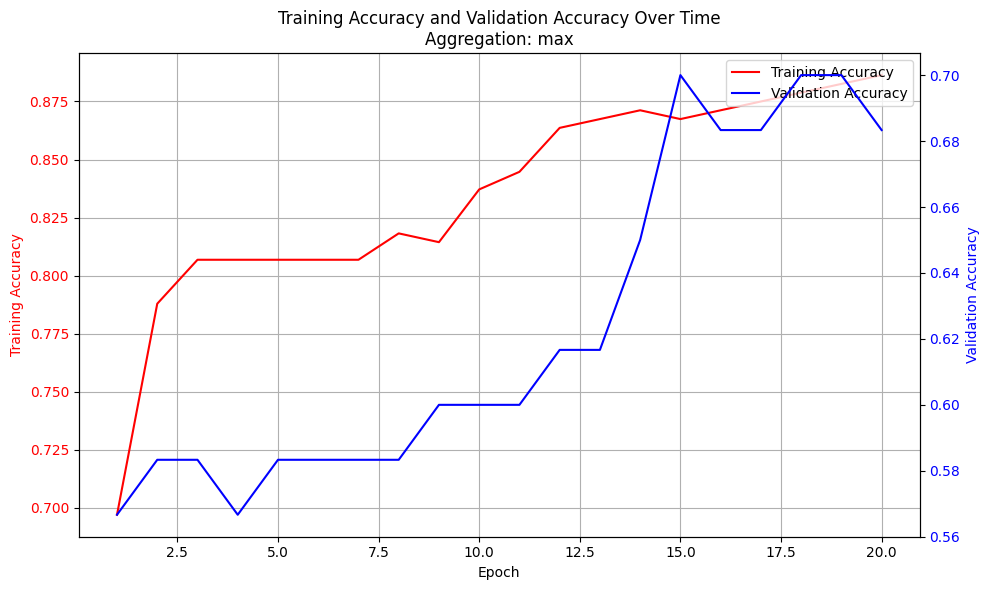

<Figure size 1000x600 with 0 Axes>

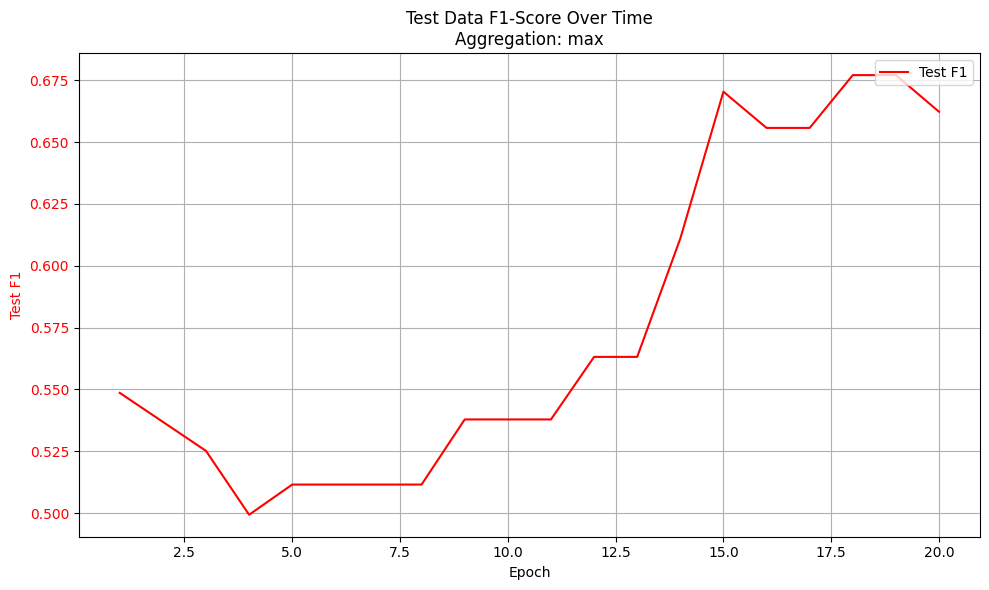

Epoch 1, Training Loss: 0.5798798862897663, Train Accuracy: 0.803030303030303, Validation Accuracy: 0.6167
Epoch 2, Training Loss: 0.5331085954928285, Train Accuracy: 0.803030303030303, Validation Accuracy: 0.6167
Epoch 3, Training Loss: 0.5102223698688083, Train Accuracy: 0.803030303030303, Validation Accuracy: 0.6500
Epoch 4, Training Loss: 0.48734649925509904, Train Accuracy: 0.8143939393939394, Validation Accuracy: 0.6333
Epoch 5, Training Loss: 0.46616876832536724, Train Accuracy: 0.8333333333333334, Validation Accuracy: 0.6500
Epoch 6, Training Loss: 0.44905662469505897, Train Accuracy: 0.8409090909090909, Validation Accuracy: 0.6500
Epoch 7, Training Loss: 0.4352820937232481, Train Accuracy: 0.8484848484848485, Validation Accuracy: 0.6833
Epoch 8, Training Loss: 0.4222116728743651, Train Accuracy: 0.8295454545454546, Validation Accuracy: 0.6667
Epoch 9, Training Loss: 0.41148393390044063, Train Accuracy: 0.8371212121212122, Validation Accuracy: 0.6667
Epoch 10, Training Loss: 0.

<Figure size 1000x600 with 0 Axes>

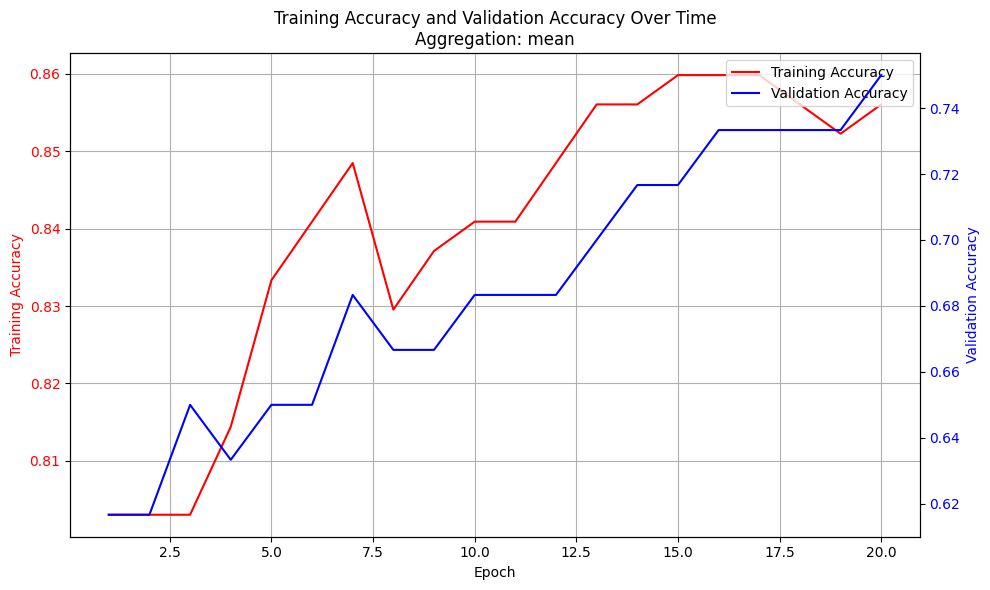

<Figure size 1000x600 with 0 Axes>

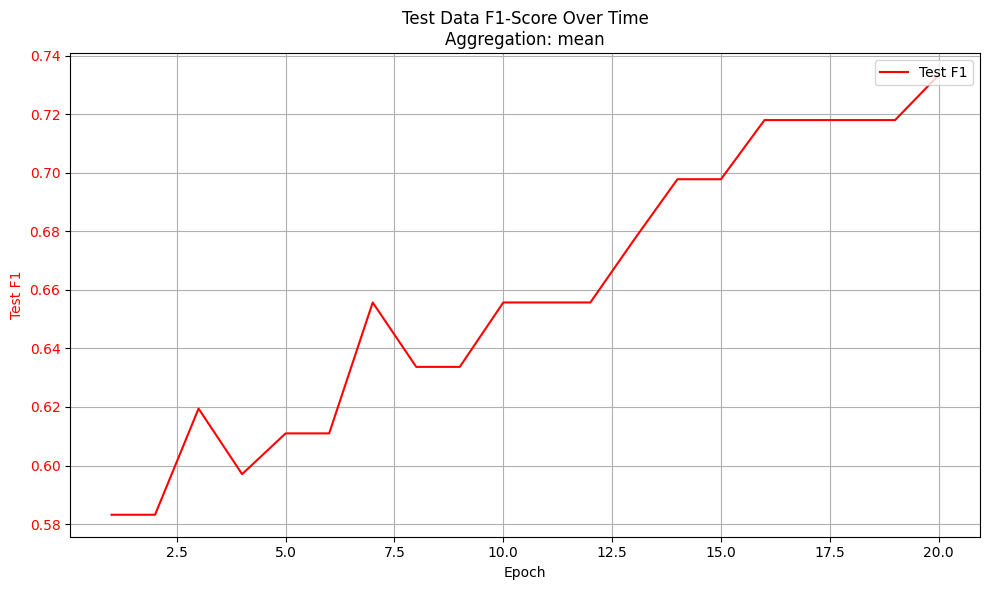

Epoch 1, Training Loss: 0.6988002772303853, Train Accuracy: 0.8143939393939394, Validation Accuracy: 0.6833
Epoch 2, Training Loss: 0.5909390097996093, Train Accuracy: 0.8106060606060606, Validation Accuracy: 0.6833
Epoch 3, Training Loss: 0.5395614721709342, Train Accuracy: 0.8106060606060606, Validation Accuracy: 0.6667
Epoch 4, Training Loss: 0.4978585580905598, Train Accuracy: 0.8181818181818182, Validation Accuracy: 0.6667
Epoch 5, Training Loss: 0.4611742328662799, Train Accuracy: 0.8295454545454546, Validation Accuracy: 0.6833
Epoch 6, Training Loss: 0.4250948251777145, Train Accuracy: 0.8295454545454546, Validation Accuracy: 0.6833
Epoch 7, Training Loss: 0.39827397427253536, Train Accuracy: 0.8333333333333334, Validation Accuracy: 0.6833
Epoch 8, Training Loss: 0.3821222985301795, Train Accuracy: 0.8409090909090909, Validation Accuracy: 0.6667
Epoch 9, Training Loss: 0.37039054113009834, Train Accuracy: 0.8409090909090909, Validation Accuracy: 0.6667
Epoch 10, Training Loss: 0

<Figure size 1000x600 with 0 Axes>

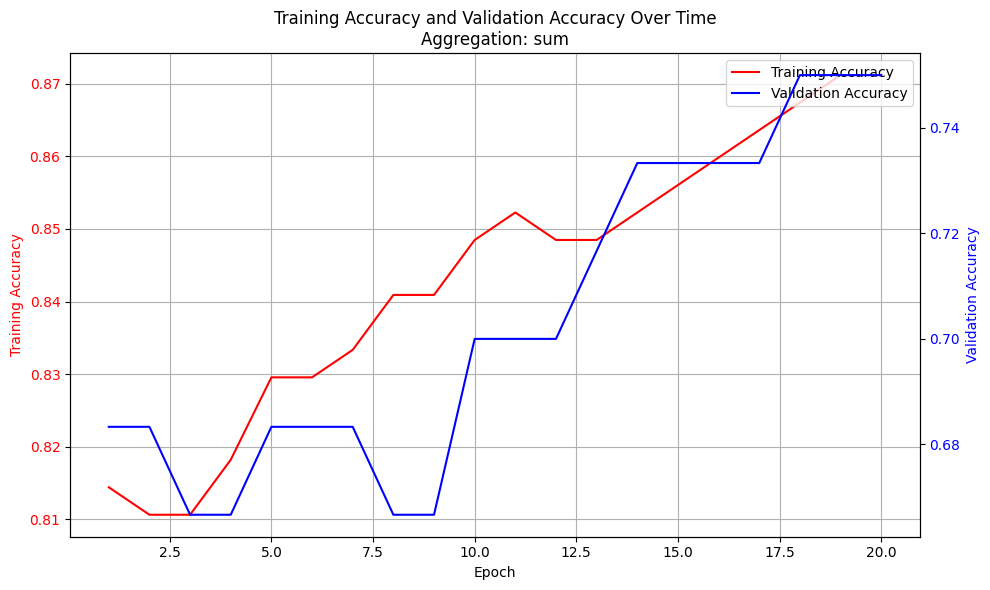

<Figure size 1000x600 with 0 Axes>

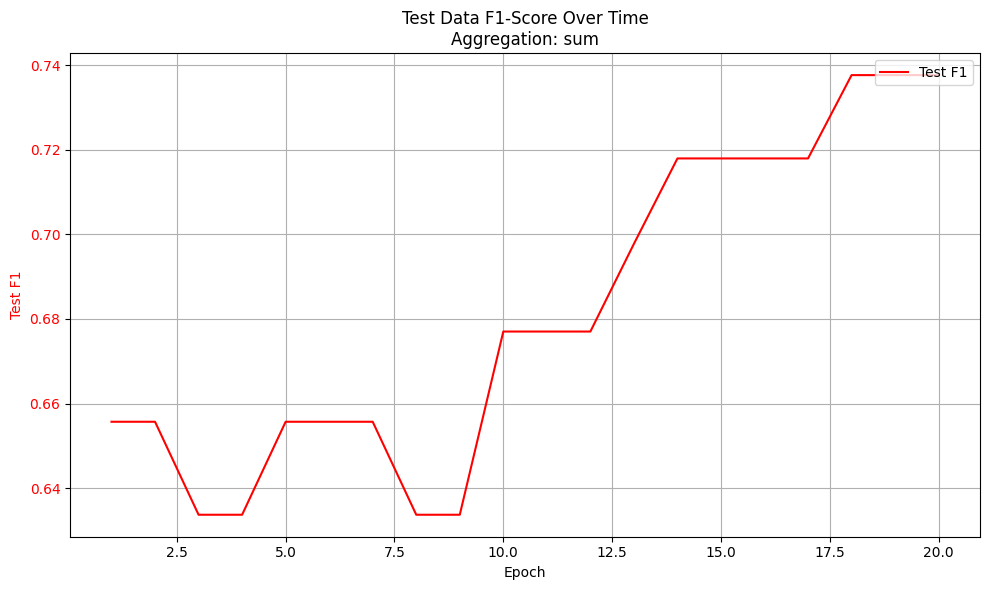

In [28]:
# Run all three aggregation functions here.
# Load data
train_data = read_json_data(TRAIN_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label
eval_data = read_json_data(EVAL_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label

# Initialising the model
input_dim = 10
hidden_dim = 8
max_aggregation_model = MyGraphNeuralNetwork(input_dim, hidden_dim)
print(max_aggregation_model)
mean_aggregation_model = MyGraphNeuralNetwork(input_dim, hidden_dim)
print(mean_aggregation_model)
sum_aggregation_model = MyGraphNeuralNetwork(input_dim, hidden_dim)
print(sum_aggregation_model)


# Loss function and optimizer
max_aggregation_criterion = nn.BCELoss()
max_aggregation_optimizer = optim.Adam(max_aggregation_model.parameters(), lr=0.001)
mean_aggregation_criterion = nn.BCELoss()
mean_aggregation_optimizer = optim.Adam(mean_aggregation_model.parameters(), lr=0.001)
sum_aggregation_criterion = nn.BCELoss()
sum_aggregation_optimizer = optim.Adam(sum_aggregation_model.parameters(), lr=0.001)

models = [max_aggregation_model, mean_aggregation_model, sum_aggregation_model]
criteria = [max_aggregation_criterion, mean_aggregation_criterion, sum_aggregation_criterion]
optimizers = [max_aggregation_optimizer, mean_aggregation_optimizer, sum_aggregation_optimizer]

# Save f1 scores per aggregation method to use in 1.1.c
train_f1_dict = {}
eval_f1_dict = {}

# TRAIN
for i in range(len(models)):
    num_epochs = 20
    train_losses, train_acc, eval_acc, train_f1, eval_f1 = train_model(
        models[i], 
        optimizers[i], 
        criteria[i], 
        train_data, 
        eval_data, 
        epochs=num_epochs, 
        graph_aggregation_method="max",
        verbose=True
    )

    train_f1_dict[["max", "mean", "sum"][i]] = train_f1
    eval_f1_dict[["max", "mean", "sum"][i]] = eval_f1

    # Visualising training and validation accuracy
    plot_training_and_validation(graph1_vals=train_acc, graph2_vals=eval_acc, aggregation=["max", "mean", "sum"][i])

    # Visualising test f1
    plot_training_and_validation(graph1_vals=eval_f1, aggregation=["max", "mean", "sum"][i], graph1_label="Test F1", title="Test Data F1-Score Over Time")

### Q1.1.c - Training vs. Evaluation F1

Additionally, compare training F1 scores vs. evaluation F1 scores. What differences do you
observe? Which aggregation function performs best and why (sum, mean, or max)?

<Figure size 1000x600 with 0 Axes>

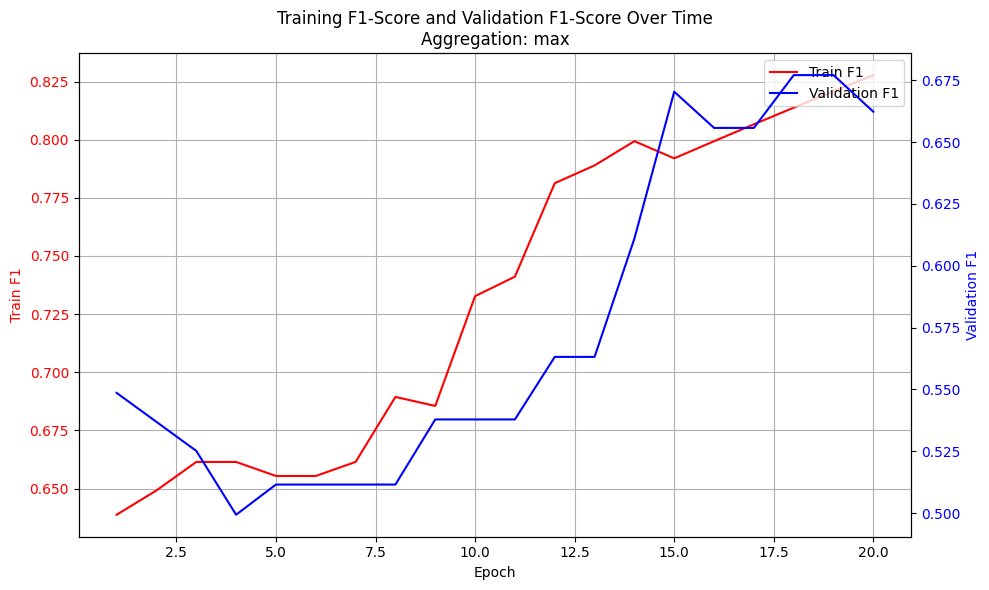

<Figure size 1000x600 with 0 Axes>

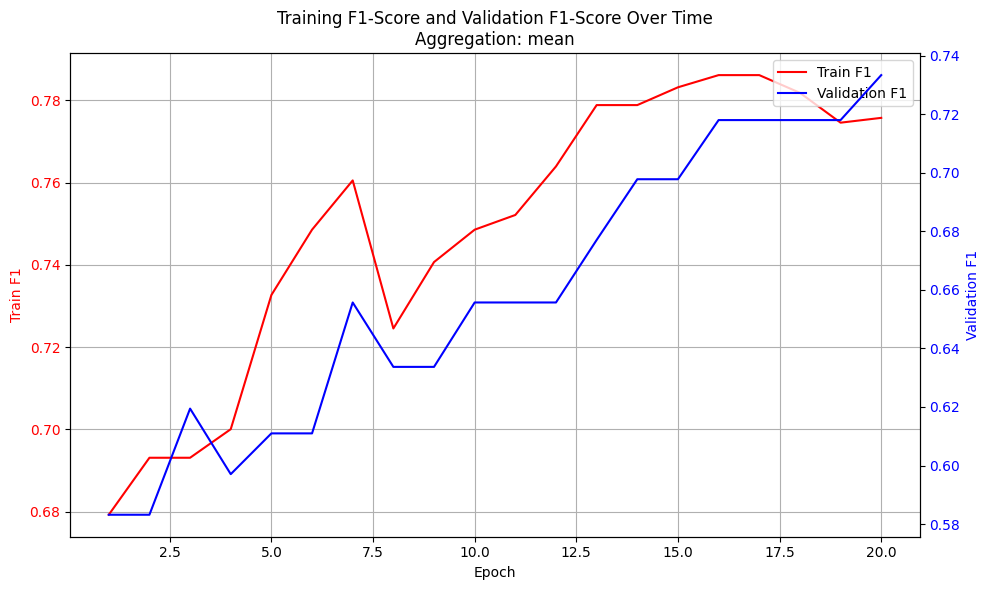

<Figure size 1000x600 with 0 Axes>

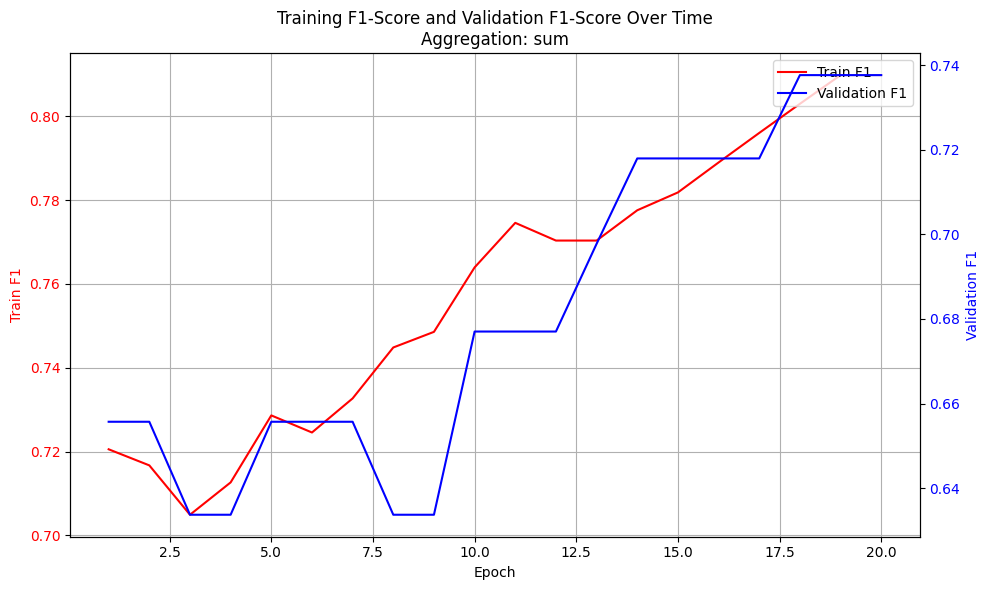

In [29]:
# Solution Q1.1.c
# ####################################################
# MODIFY THE CODE BELOW 
# ####################################################  

for aggregation in ["max", "mean", "sum"]:
    plot_training_and_validation(
        graph1_vals=train_f1_dict[aggregation], 
        graph2_vals=eval_f1_dict[aggregation], 
        aggregation=aggregation, 
        graph1_label="Train F1", 
        graph2_label="Validation F1", 
        title="Training F1-Score and Validation F1-Score Over Time"
    )

# ####################################################
# END OF MODIFICATION
# ####################################################  


## Q1.2 - Analyzing the Dataset

You may notice that the model performs worse on the evaluation dataset. The goal of this task
is to analyze the dataset and identify potential issues that might affect the model’s performance.


In [32]:
# Helper function to visualise graphs:
def visualize_graph(G):
    """Visualize the generated graph."""
    pos = nx.spring_layout(G)

    # Draw the graph
    plt.figure(figsize=(12, 8))
    nx.draw(
        G, pos, with_labels=True,
        node_size=500, font_size=8, font_color="white", edge_color="gray"
    )
    plt.title("Homogenous Graph Visualization")
    plt.show()

def visualise_graph_features(features_0, features_1):
    """plot clusters and their distribution"""
    plt.figure(figsize=(12, 8))
    
    # Convert to numpy arrays and get the first feature dimension
    features_0_np_1 = np.array(features_0)[:, 0]  # Take first feature dimension
    features_0_np_2 = np.array(features_0)[:, 1]  # Take second feature dimension
    
    features_1_np_1 = np.array(features_1)[:, 0]  # Take first feature dimension
    features_1_np_2 = np.array(features_1)[:, 1]  # Take first feature dimension
   
    plt.scatter(features_0_np_1, features_0_np_2, alpha=0.6, label='Class 0', color='red')
    plt.scatter(features_1_np_1, features_1_np_2, alpha=0.6, label='Class 1', color='blue')

    plt.xlabel('First Feature Dimension')
    plt.ylabel('Class') 
    plt.title('Feature Distribution by Class')
    plt.yticks([0, 1], ['Class 0', 'Class 1'])
    plt.legend()
    plt.show()

### Q1.2.a - Plotting
• Plot the topologies of the graphs.

• Plot the feature distributions.

• Plot the label distributions.

In [42]:
# ####################################################
# MODIFY THE CODE BELOW 
# ####################################################  
def plot_class_distribution(labels):
    """Plots the distribution of labels"""
    # Plot the distributions of the labels
    plt.figure(figsize=(12, 8))
    plt.hist(labels, bins=3, alpha=0.6, color='blue', edgecolor='black')
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.title('Label Class Distribution')
    plt.xticks([0, 1], ['Class 0', 'Class 1'])
    plt.show()


def plot_graph_topology(A):
    """Plots the graph topology"""
    G = nx.from_numpy_array(A.numpy())
    visualize_graph(G)

    

# ####################################################
# END OF MODIFICATION
# #################################################### 

Training dataset label class distribution


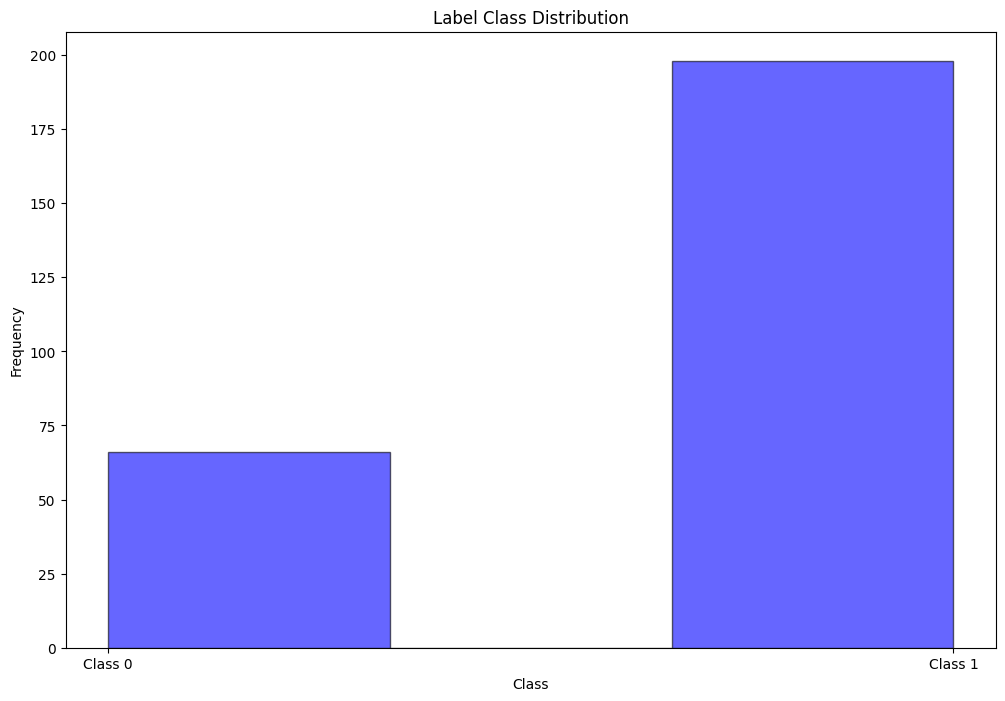

Training dataset feature distribution by class


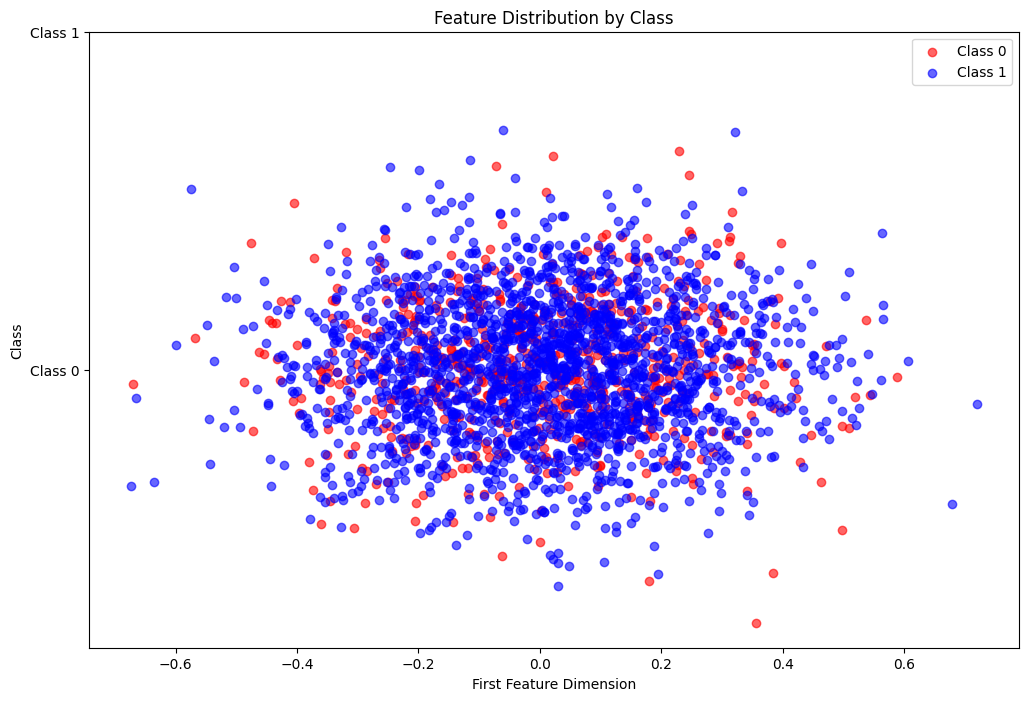

Training Dataset Graph Topology for Class 0


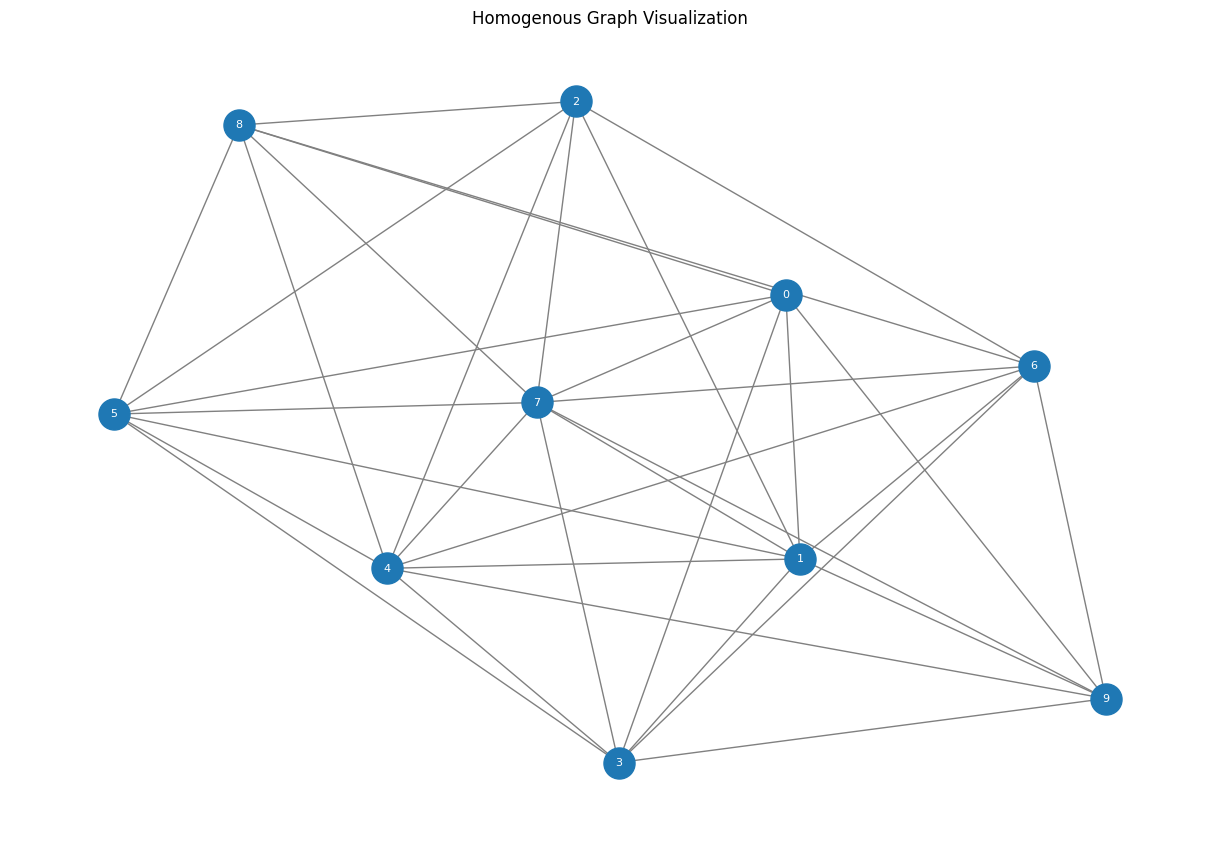

Training Dataset Graph Topology for Class 1


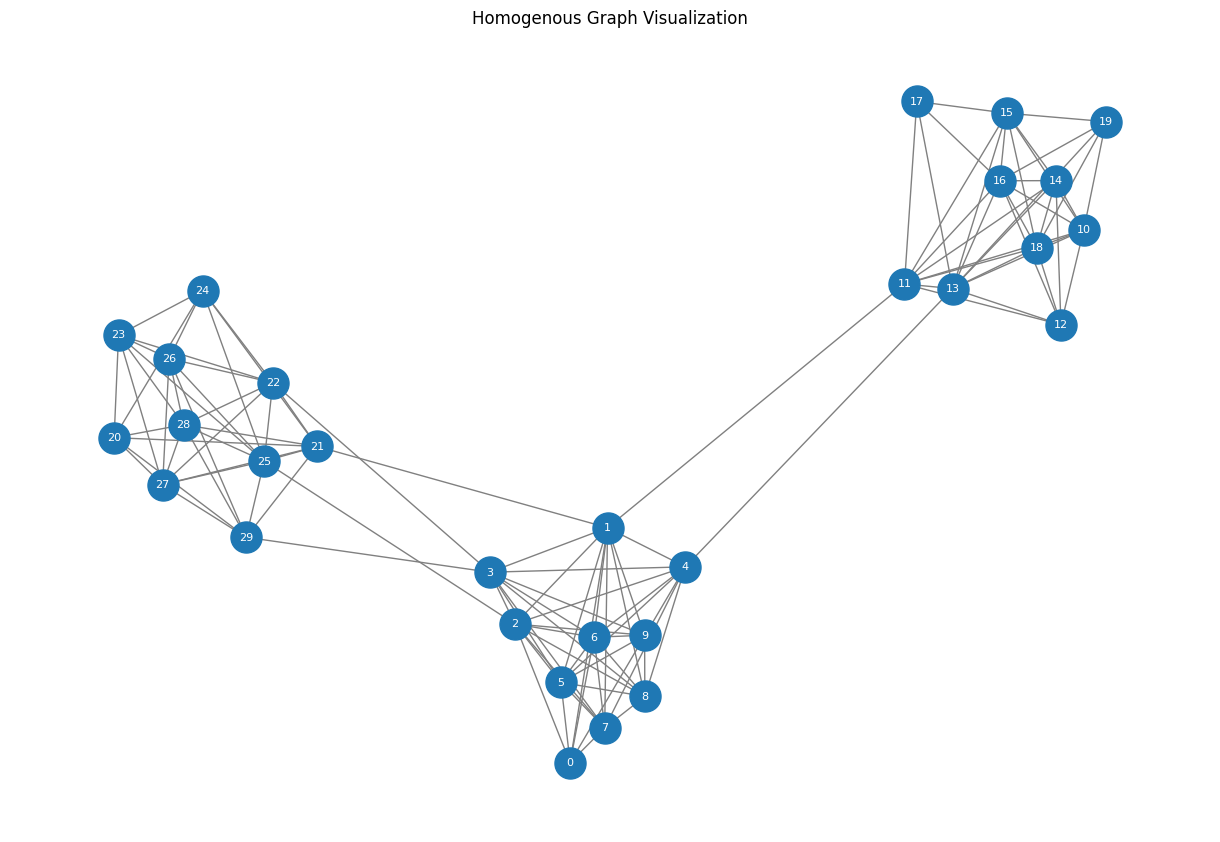

Evaluation dataset label class distribution


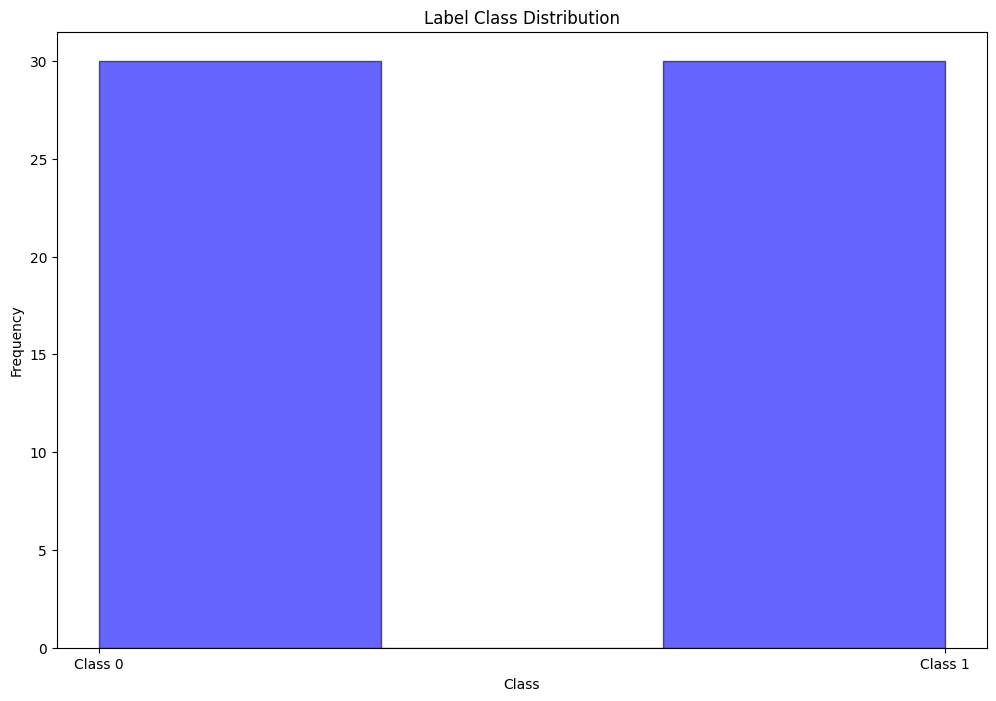

Evaluation dataset feature distribution by class


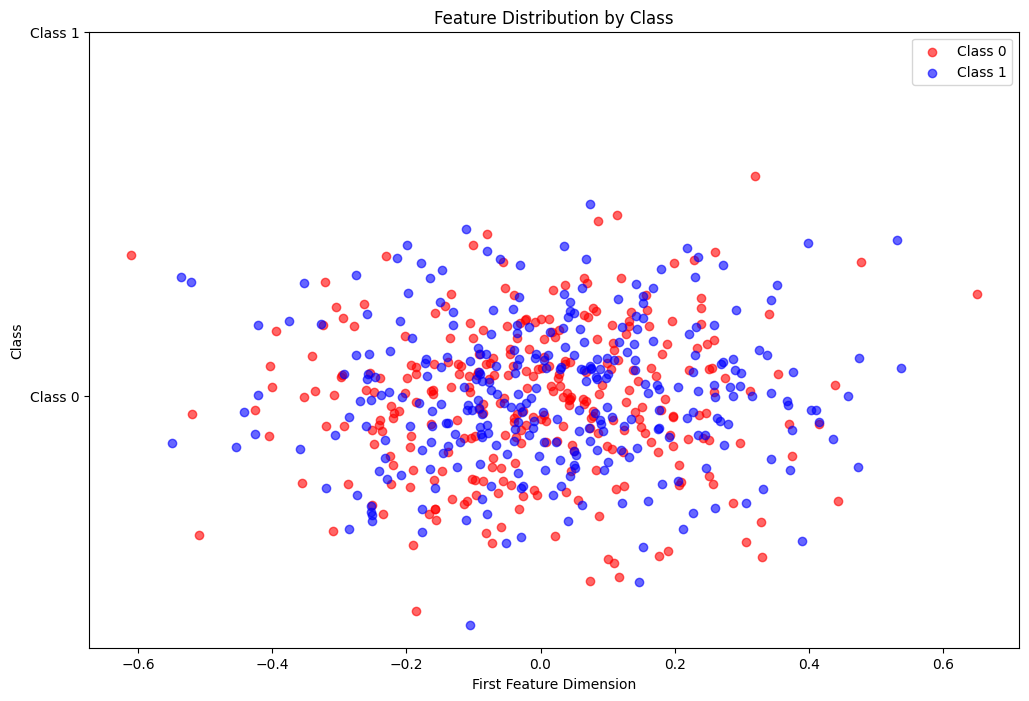

Evaluation Dataset Graph Topology for Class 0


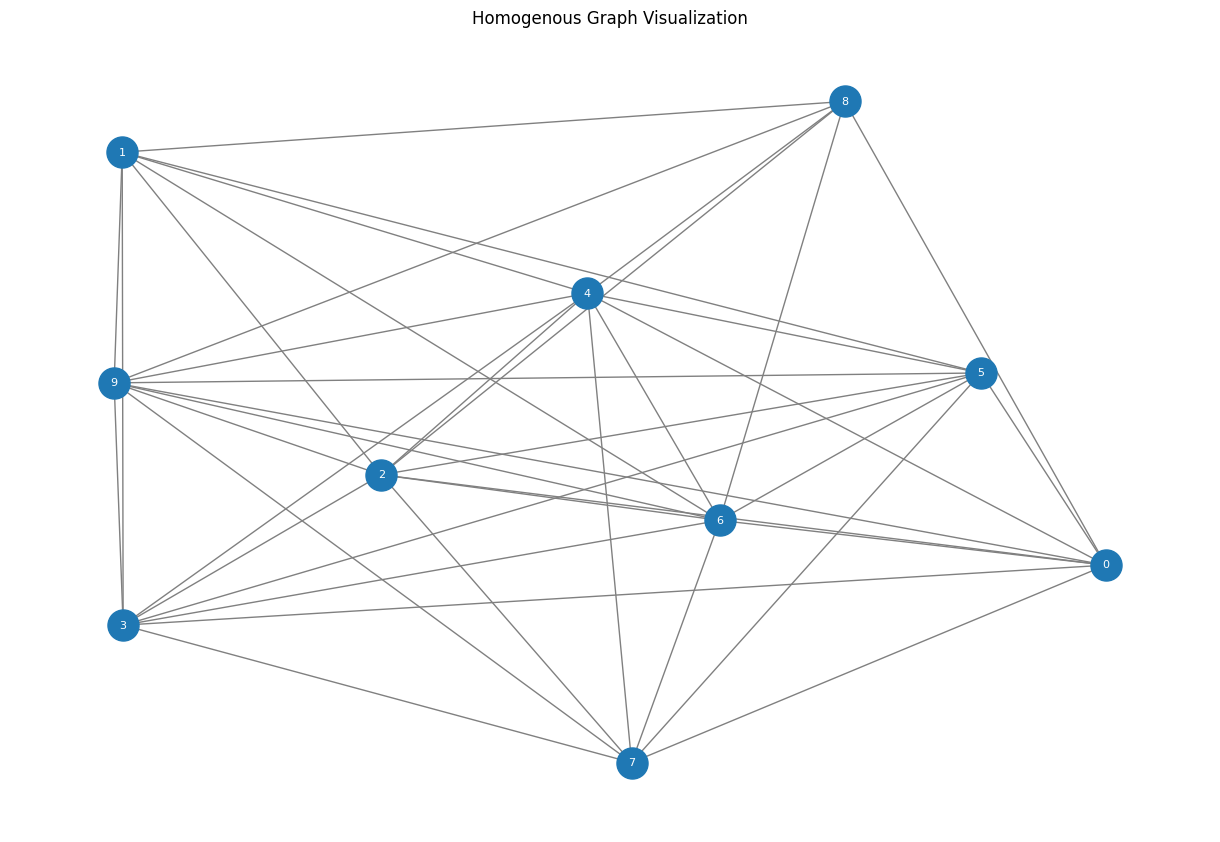

Evaluation Dataset Graph Topology for Class 1


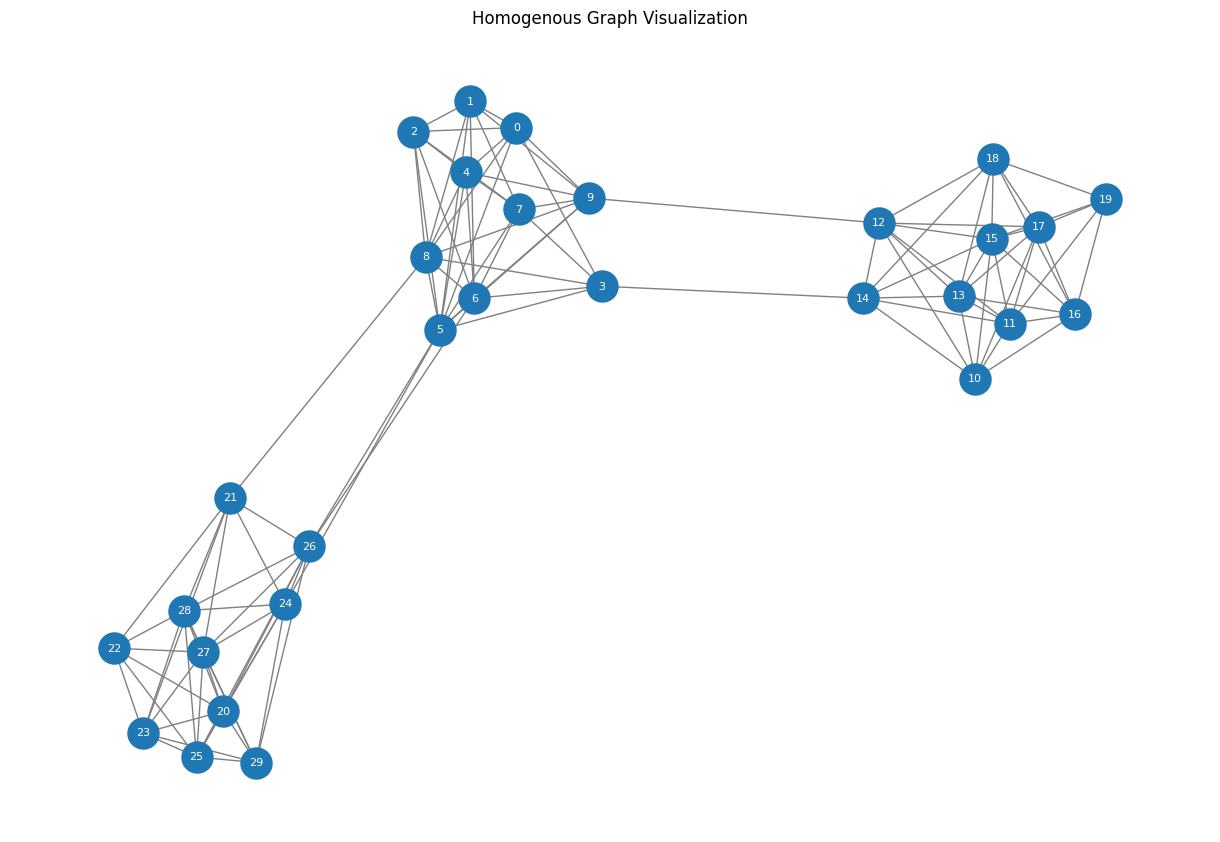

In [44]:
# Run the above scripts for train and eval. What do you observe?
def find_X_A_for_label(list_of_data,label=1):
    """Label"""
    for X,A,y in list_of_data:
        if y==label:
            return X,A

# Load data
train_data = read_json_data(TRAIN_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label
eval_data = read_json_data(EVAL_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label

# Getting Labels
train_labels = [int(y) for _,_,y in train_data]
eval_labels = [int(y) for _,_,y in eval_data]

# Getting Features
train_features_0 = [X.numpy() for X, _, y in train_data if y == 0]
train_features_1 = [X.numpy() for X, _, y in train_data if y == 1]

eval_features_0 = [X.numpy() for X, _, y in eval_data if y == 0]
eval_features_1 = [X.numpy() for X, _, y in eval_data if y == 1]

# Find a graph for each of the classes
X0_train, A0_train = find_X_A_for_label(train_data, 0)
X1_train, A1_train = find_X_A_for_label(train_data, 1)

X0_eval,A0_eval = find_X_A_for_label(eval_data, 0)
X1_eval, A1_eval = find_X_A_for_label(eval_data, 1)

# Plotting Train
print("Training dataset label class distribution")
plot_class_distribution(train_labels)
print("Training dataset feature distribution by class")
visualise_graph_features(train_features_0, train_features_1)
print("Training Dataset Graph Topology for Class 0")
plot_graph_topology(A0_train)
print("Training Dataset Graph Topology for Class 1")
plot_graph_topology(A1_train)

# Plotting Eval
print("Evaluation dataset label class distribution")
plot_class_distribution(eval_labels)
print("Evaluation dataset feature distribution by class")
visualise_graph_features(eval_features_0, eval_features_1)
print("Evaluation Dataset Graph Topology for Class 0")
plot_graph_topology(A0_eval)
print("Evaluation Dataset Graph Topology for Class 1")
plot_graph_topology(A1_eval)





## Question 1.3 - Overcoming Dataset Challenges

In this section, you will attempt to address the challenges identified by improving the model or training process.

### Q1.3.a - Adapting the GCN

Modify your GCN implementation from Q1.1 to accept the number of layers and output dimen-
sion (i.e. the graph embedding dimension) as parametes. Experiment with different hyperparam-
eters, such as:

• Number of layers.

• Hidden dimension size.

You will implement:

• Implement GCN as described above.

• Experiment with hyperparameters and report the results and plots.

Hint: The ModuleList class might be useful.

In [47]:
# SOLUTION Q1.3.a

# ####################################################
# MODIFY THE CODE BELOW 
# ####################################################

# Use MODULELIST
# nn.ModuleList

class MyGCNLayer2(nn.Module):
    """
    A single layer of a Graph Convolutional Network (GCN).
    """
    def __init__(self, input_dim, output_dim, use_nonlinearity=True):
        super(MyGCNLayer2, self).__init__()
        self.use_nonlinearity = use_nonlinearity
        self.Omega = nn.Parameter(torch.randn(input_dim, output_dim) * torch.sqrt(torch.tensor(2.0) / (input_dim + output_dim)))
        self.beta = nn.Parameter(torch.zeros(output_dim))

    def forward(self, H_k, A_normalized):
        agg = torch.matmul(A_normalized, H_k) # local agg
        H_k_next = torch.matmul(agg, self.Omega) + self.beta
        return F.relu(H_k_next) if self.use_nonlinearity else H_k_next

class MyGraphNeuralNetwork2(nn.Module):
    """
    A simple Graph Neural Network model using two layers of Graph Convolutional Network (GCN)
    for binary classification. The sigmoid activation is applied in the output layer only if
    use_nonlinearity is set to True.
    """
    def __init__(self, input_dim, hidden_dim, num_layers=2, output_dim=1):
        super(MyGraphNeuralNetwork2, self).__init__()   
        self.gcn_layers = nn.ModuleList()
        for layer in range(num_layers):
            if layer == 0:
                self.gcn_layers.append(MyGCNLayer2(input_dim, hidden_dim, True))
            elif layer == num_layers - 1:
                self.gcn_layers.append(MyGCNLayer2(hidden_dim, output_dim, False))
            else:
                self.gcn_layers.append(MyGCNLayer2(hidden_dim, hidden_dim, True))
            

    def forward(self, A, X, graph_aggregation_method='mean', **kwargs):
        # Pass through GCN layers
        for layer in (self.gcn_layers):
            X = layer(X, A)
        
        output = torch.sigmoid(X)
        graph_output = output

        if torch.isnan(graph_output).any():
            graph_output = torch.where(torch.isnan(graph_output), torch.zeros_like(graph_output), graph_output)
        
        if graph_aggregation_method == "sum":
            graph_output = torch.sum(graph_output, dim=0)
            # This gives an error in the binary cross-entropy loss function: RuntimeError: all elements of input should be between 0 and 1
            # Because sum is over 1
            # So apply tanh to sum, this avoids large values tending too close to 1 (with sigmoid). Since input sum is always positive, tanh gives a value between 0 and 1.
            graph_output = torch.tanh(graph_output)
        elif graph_aggregation_method == "mean":
            graph_output = torch.mean(graph_output, dim=0)
        elif graph_aggregation_method == "max":
            graph_output = torch.max(graph_output, dim=0).values

        # Create the graph_embedding variable
        graph_embedding = X


        if kwargs.get("return_graph_embedding", None):
            return graph_output, graph_embedding
        else:
            return graph_output
        
# ####################################################
# END OF MODIFICATION
# ####################################################

In [49]:
# from sklearn.model_selection import train_test_split
# Run different hyper params here

# Load data
train_data = read_json_data(TRAIN_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label
eval_data = read_json_data(EVAL_DATA_PATH, has_label=True) #returns a list of (X,A,y) - features, Adj Matrix, per Graph label

# Initialising the model
input_dim = 10
hidden_dim = 8
layers = 2
output_dim = 8
model = MyGraphNeuralNetwork2(input_dim, hidden_dim, output_dim=output_dim, num_layers = layers)
print(model)

# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Splitting the Data
# train_data, val_data = train_test_split(train_data,0.8)

# TRAIN
num_epochs = 20
train_losses, train_acc, eval_acc, train_f1, eval_f1 = train_model(
    model, 
    optimizer, 
    criterion, 
    train_data, 
    eval_data, #plotting eval data on purpose to see how eval dataset performance looks like
    epochs=num_epochs, 
    graph_aggregation_method="mean",
    verbose=True
)

# Visualising
plot_training_and_validation(train_acc, eval_acc, "mean")

MyGraphNeuralNetwork2(
  (gcn_layers): ModuleList(
    (0-1): 2 x MyGCNLayer2()
  )
)


ValueError: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([8])) is deprecated. Please ensure they have the same size.

### Q1.3.b - Improving the Model
Identify and implement three different methods to overcome the challenges discovered in
Q1.2. Your goal is to achieve the highest possible score. You may experiment with:

• Model architecture modifications.

• Data preprocessing techniques.

• Hyperparameter tuning.

• Loss function adjustments.

In [ ]:
# SOLUTION Q1.3.b

# ####################################################
# MODIFY THE CODE BELOW 
# ####################################################


# Call this function in the end.
plot_training_and_validation(train_acc, eval_acc)

# ####################################################
# END OF MODIFICATION
# ####################################################

### Q1.3.c - Evaluating the Best Model

Plot the performance of your best model over 100 epochs or more, averaged over multiple
random (i.i.d.) runs (at least 10 runs) to produce a smoothed training and evaluation accuracy
curve. 

Note: Your score will be based on the smoothed curve.

Hints:

• Set verbose=False in the train model function to suppress excessive logging.

• Use np.mean with an axis parameter to compute the average performance over multiple
runs.


In [ ]:
# SOLUTION Q1.3.c - Smooth Curve

# ####################################################
# MODIFY THE CODE BELOW 
# ####################################################


# Call this function in the end (with the averaged values)
plot_training_and_validation(averaged_train_acc, averaged_eval_acc)

# ####################################################
# END OF MODIFICATION
# ####################################################